# Research question 2

## Tongues

### How does the language and country of a movie influence its box office revenue?

The goal is to analyse in more detail how the language(s) and the country of origin of a movie influence it's box office revenue.

### Imports and data loading

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
from collections import Counter
import ast 
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split


In [2]:
# set global variables
DATA_PATH = '../data/'
MOVIES_FILE = 'movies_combined_inflated.csv'

In [3]:
# load the data
df_movies = pd.read_csv(DATA_PATH + MOVIES_FILE)
df_movies.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,release_year,...,combined_revenue,release_month,release_day,primaryTitle,startYear,averageRating,numVotes,tconst,director,inflated_revenue
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]","[('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...",2001.0,...,14010832.0,8.0,24.0,Ghosts of Mars,2001.0,4.9,58868.0,tt0228333,John Carpenter,1.899115e+07
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]","[('/m/04t36', 'Musical'), ('/m/01z4y', 'Comedy...",1938.0,...,4000000.0,8.0,16.0,Alexander's Ragtime Band,1938.0,6.8,2357.0,tt0029852,Henry King,6.812740e+07
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"[('/m/02h40lc', 'English Language')]","[('/m/07ssc', 'United Kingdom')]","[('/m/04xvh5', 'Costume drama'), ('/m/082gq', ...",1989.0,...,10161099.0,11.0,8.0,Henry V,1989.0,7.5,32088.0,tt0097499,Kenneth Branagh,1.967252e+07
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]","[('/m/0hj3myq', ""Children's/Family""), ('/m/04t...",1964.0,...,102272727.0,8.0,27.0,Mary Poppins,1964.0,7.8,189183.0,tt0058331,Robert Stevenson,7.913870e+08
4,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]","[('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...",1999.0,...,21521.0,10.0,1.0,NaN,NaN,0.0,0.0,NaN,Unknown,3.100822e+04


### Data pre-processing

A new, reduced dataframe can be created by only taking the relevant columns for this specific research question. The following columns are necessary:
- 'movie_name'
- 'movie_languages'
- 'movie_countries'
- 'inflated_revenue'

Three different dataframes are created:
- df_movie_country -> specific to the country only
- df_movie_language -> specific to the language only
- df_movie_country_language -> for both country and language 

In each dataframe, rows that don't contain any value for on of the mentioned columns are removed. 

In [4]:
# create the specific dataframes
df_movie_country = df_movies[["movie_name", "movie_countries", "inflated_revenue"]]
df_movie_language = df_movies[["movie_name", "movie_languages", "inflated_revenue"]]
df_movie_country_language = df_movies[["movie_name", "movie_languages", "movie_countries", "inflated_revenue"]]

# drop rows with missing values
df_movie_country.dropna(inplace=True)
df_movie_language.dropna(inplace=True)
df_movie_country_language.dropna(inplace=True)

C:\Users\celin\AppData\Local\Temp\ipykernel_7504\2450804310.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_country.dropna(inplace=True)
C:\Users\celin\AppData\Local\Temp\ipykernel_7504\2450804310.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_language.dropna(inplace=True)
C:\Users\celin\AppData\Local\Temp\ipykernel_7504\2450804310.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_country_language.

In [5]:
# print the number of rows where the movie_countries list is empty
print("Number of rows where movie_countries list is empty: ", df_movie_country[df_movie_country["movie_countries"] == "[]"].shape[0])
# print the number of rows where the movie_languages list is empty
print("Number of rows where movie_languages list is empty: ", df_movie_language[df_movie_language["movie_languages"] == "[]"].shape[0])

# remove such rows
df_movie_country = df_movie_country[df_movie_country["movie_countries"].apply(lambda x: len(ast.literal_eval(x)) > 0)]
df_movie_language = df_movie_language[df_movie_language["movie_languages"].apply(lambda x: len(ast.literal_eval(x)) > 0)]

# safety check
print('-----Preprocessed Data-----')
print("Number of rows where movie_countries list is empty: ", df_movie_country[df_movie_country["movie_countries"] == "[]"].shape[0])
print("Number of rows where movie_languages list is empty: ", df_movie_language[df_movie_language["movie_languages"] == "[]"].shape[0])


Number of rows where movie_countries list is empty:  131
Number of rows where movie_languages list is empty:  344
-----Preprocessed Data-----
Number of rows where movie_countries list is empty:  0
Number of rows where movie_languages list is empty:  0


In [6]:
# check for duplicates
print("Duplicates in df_movie_country: ", df_movie_country.duplicated().sum())
print("Duplicates in df_movie_language: ", df_movie_language.duplicated().sum())
print("Duplicates in df_movie_country_language: ", df_movie_country_language.duplicated().sum())

# remove duplicates
df_movie_country.drop_duplicates(inplace=True)
df_movie_language.drop_duplicates(inplace=True)
df_movie_country_language.drop_duplicates(inplace=True)

# safety check
print('-----Preprocessed Data-----')
print("Duplicates in df_movie_country: ", df_movie_country.duplicated().sum())
print("Duplicates in df_movie_language: ", df_movie_language.duplicated().sum())
print("Duplicates in df_movie_country_language: ", df_movie_country_language.duplicated().sum())

Duplicates in df_movie_country:  15
Duplicates in df_movie_language:  15
Duplicates in df_movie_country_language:  12
-----Preprocessed Data-----
Duplicates in df_movie_country:  0
Duplicates in df_movie_language:  0
Duplicates in df_movie_country_language:  0


C:\Users\celin\AppData\Local\Temp\ipykernel_7504\2100252554.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie_country_language.drop_duplicates(inplace=True)


In [7]:
df_movie_country.head()

,movie_name,movie_countries,inflated_revenue
0,Ghosts of Mars,"[('/m/09c7w0', 'United States of America')]",1.899115e+07
1,Alexander's Ragtime Band,"[('/m/09c7w0', 'United States of America')]",6.812740e+07
2,Henry V,"[('/m/07ssc', 'United Kingdom')]",1.967252e+07
3,Mary Poppins,"[('/m/09c7w0', 'United States of America')]",7.913870e+08
4,New Rose Hotel,"[('/m/09c7w0', 'United States of America')]",3.100822e+04


In [8]:
df_movie_language.head()

,movie_name,movie_languages,inflated_revenue
0,Ghosts of Mars,"[('/m/02h40lc', 'English Language')]",1.899115e+07
1,Alexander's Ragtime Band,"[('/m/02h40lc', 'English Language')]",6.812740e+07
2,Henry V,"[('/m/02h40lc', 'English Language')]",1.967252e+07
3,Mary Poppins,"[('/m/02h40lc', 'English Language')]",7.913870e+08
4,New Rose Hotel,"[('/m/02h40lc', 'English Language')]",3.100822e+04


In [9]:
df_movie_country_language.head()

,movie_name,movie_languages,movie_countries,inflated_revenue
0,Ghosts of Mars,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]",1.899115e+07
1,Alexander's Ragtime Band,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]",6.812740e+07
2,Henry V,"[('/m/02h40lc', 'English Language')]","[('/m/07ssc', 'United Kingdom')]",1.967252e+07
3,Mary Poppins,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]",7.913870e+08
4,New Rose Hotel,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]",3.100822e+04


### Some intial exploration

How many countries/ languages does the dataset have? Which ones are the most common one?

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the number of countries and languages in the dataset
  - Think about how this distribution could influence/ change further analysis
  
</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Extract the unique country and language names and print the absolute frequency for the most common ones
  - Print the total number of different countries and languages
  - Visualization: Plot the most common countries and languages in a bar chart
</div>

In [10]:
def extract_names(columns):
    """
    Extracts the names from columns of the data (for countries and languages for example)
    Args:
        columns: list of columns
    Returns:
        names: list of names
    """
    names = []
    for column in columns:
        literals = ast.literal_eval(column)
        names.extend([literals[1] for literals in literals])
    return names


In [11]:
# extract all possible countries and languages
countries = extract_names(df_movie_country_language['movie_countries'])
languages = extract_names(df_movie_country_language['movie_languages'])

# count 
countries_count = pd.Series(countries).value_counts()
languages_count = pd.Series(languages).value_counts()

# print the top 10 countries and languages
print(f'Top 10 countries:\n{countries_count.head(10)}')
print(f'Top 10 languages:\n{languages_count.head(10)}')

Top 10 countries:
United States of America    7691
United Kingdom              1121
France                       634
Germany                      519
Canada                       388
South Korea                  282
Japan                        237
Australia                    216
Italy                        196
India                        134
Name: count, dtype: int64
Top 10 languages:
English Language     8344
French Language       644
Spanish Language      484
German Language       308
Italian Language      279
Korean Language       258
Japanese Language     256
Russian Language      217
Standard Mandarin     145
Hindi Language        103
Name: count, dtype: int64


In [12]:
# print the number of different countries and languages
print(f'Number of different countries: {len(countries_count)}')
print(f'Number of different languages: {len(languages_count)}')

Number of different countries: 106
Number of different languages: 158


C:\Users\celin\AppData\Local\Temp\ipykernel_7504\951938130.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=countries_count.head(top_n).values, y=countries_count.head(top_n).index, palette='Set2')


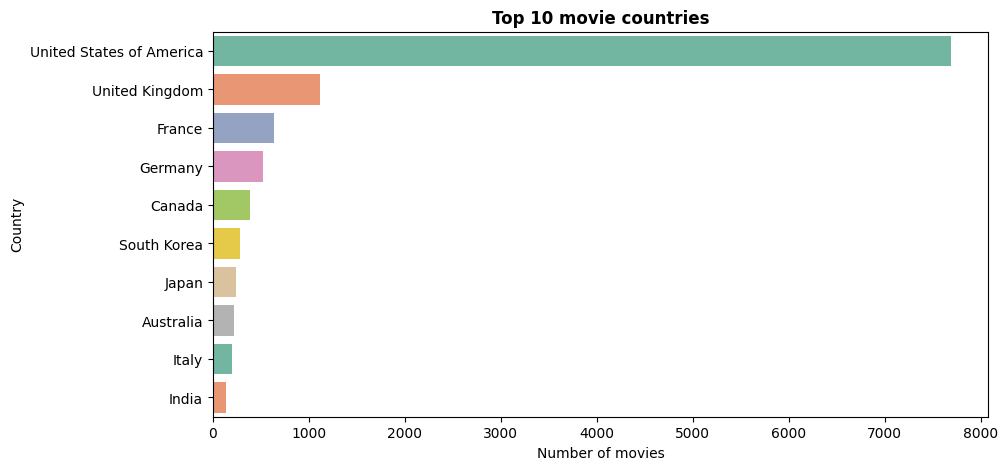

In [13]:
top_n = 10

# plot the top 10 countries
plt.figure(figsize=(10, 5))
sns.barplot(x=countries_count.head(top_n).values, y=countries_count.head(top_n).index, palette='Set2')
plt.title('Top 10 movie countries', fontweight='bold')
plt.xlabel('Number of movies')
plt.ylabel('Country')
plt.show()


C:\Users\celin\AppData\Local\Temp\ipykernel_7504\1011090576.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=languages_count.head(top_n).values, y=languages_count.head(top_n).index, palette='Set2')


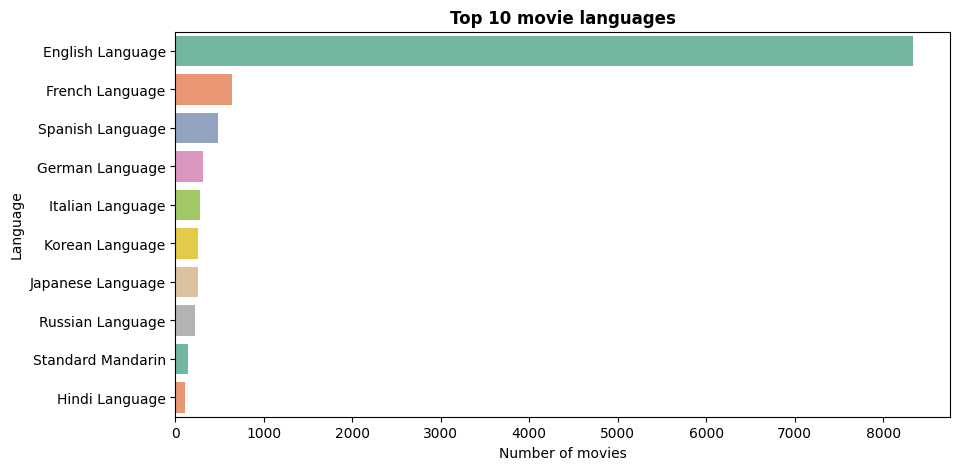

In [14]:
# plot the top 10 languages
plt.figure(figsize=(10, 5))
sns.barplot(x=languages_count.head(top_n).values, y=languages_count.head(top_n).index, palette='Set2')
plt.title('Top 10 movie languages', fontweight='bold')
plt.xlabel('Number of movies')
plt.ylabel('Language')
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Analysis of what has been found
  
</div>

### Language influence

How does the language influence the box office revenue? Do movies in widely spoken languages (for example English) tend to have higher box office revenue?

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the influence of the language on the box office revenue
  - Only consider the first mentioned language in the list of languages
  
</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Extract the first language in the language list for each movie
  - Visualization: Plot the languages and their average box office revenue in a bar chart
  - Regression analysis
  - Statistical hypothesis testing: ANOVA
  
</div>

In [15]:
def extract_first_language(language_list):
    """
    Extract only the first language of the list of all languages
    Args:
        language_list: a list of all languages for a movie
    Returns:
        first_language: the first language for the given movie
    """
    parsed_language_list = ast.literal_eval(language_list)
    first_language = parsed_language_list[0][1]

    return first_language 

In [16]:
# extract the first language for each movie
df_movie_language['first_language'] = df_movie_language['movie_languages'].apply(extract_first_language)

# check 
df_movie_language[['movie_name', 'movie_languages', 'first_language']].head(10)


,movie_name,movie_languages,first_language
0,Ghosts of Mars,"[('/m/02h40lc', 'English Language')]",English Language
1,Alexander's Ragtime Band,"[('/m/02h40lc', 'English Language')]",English Language
2,Henry V,"[('/m/02h40lc', 'English Language')]",English Language
3,Mary Poppins,"[('/m/02h40lc', 'English Language')]",English Language
4,New Rose Hotel,"[('/m/02h40lc', 'English Language')]",English Language
5,Baby Boy,"[('/m/02h40lc', 'English Language')]",English Language
6,They Knew What They Wanted,"[('/m/02h40lc', 'English Language')]",English Language
7,The Gods Must Be Crazy,"[('/m/0x82', 'Afrikaans Language'), ('/m/02h40...",Afrikaans Language
8,Rudo y Cursi,"[('/m/06nm1', 'Spanish Language')]",Spanish Language
9,Kinjite: Forbidden Subjects,"[('/m/02h40lc', 'English Language')]",English Language


In [17]:
# average box office revenue per language (only considering the fist languages for each movie)
average_revenue_per_language = df_movie_language.groupby('first_language')['inflated_revenue'].mean().sort_values(ascending=False)

C:\Users\celin\AppData\Local\Temp\ipykernel_7504\1030048985.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_revenue_per_language.head(top_n).index, y=average_revenue_per_language.head(top_n).values, palette="plasma")


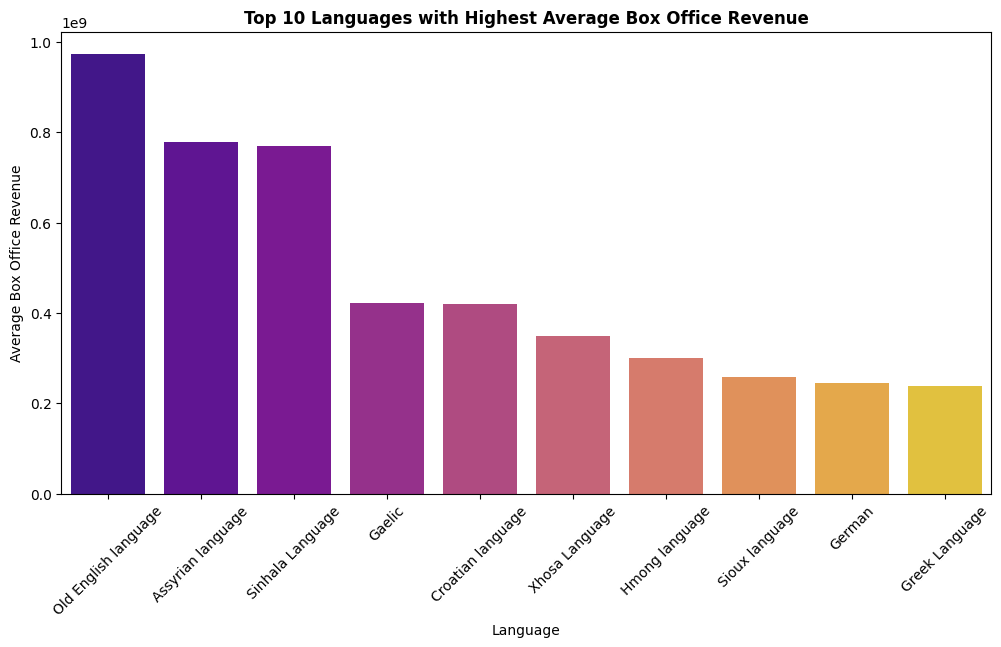

In [18]:
# plot
top_n = 10

plt.figure(figsize=(12, 6))
sns.barplot(x=average_revenue_per_language.head(top_n).index, y=average_revenue_per_language.head(top_n).values, palette="plasma")
plt.title("Top 10 Languages with Highest Average Box Office Revenue", fontweight='bold')
plt.xlabel("Language")
plt.ylabel("Average Box Office Revenue")
plt.xticks(rotation=45)
plt.show()

##### Regression analysis

The language (categorical) should predict the box office revenue (continuous). An ordinary least squares (OLS) regression can be done. The categorical variable has to be one-hot encoded. Each language will get an own coefficient, indicating its influence on the box office revenue compared to the baseline language.

In [19]:
# one-hot encode the language column
# baseline language -> the most common language
X = pd.get_dummies(df_movie_language['first_language'], drop_first=True).astype(int)

y = np.log10(df_movie_language['inflated_revenue'].astype(float))

# Add intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       inflated_revenue   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.028
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           4.01e-23
Time:                        17:36:59   Log-Likelihood:                -13691.
No. Observations:                9220   AIC:                         2.760e+04
Df Residuals:                    9112   BIC:                         2.837e+04
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [20]:
# todoooooooo -> take a threshold and remove the languages with less than that threshold

##### ANOVA

An ANOVA analysis can be done in order to determine if there are statistically significant differences in box office revenue across different languages.

In [21]:
# define and fit the model
anova_model = ols('inflated_revenue ~ C(first_language)', data=df_movie_language).fit()
# get the anova table
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print(anova_table)

                         sum_sq      df         F        PR(>F)
C(first_language)  9.263444e+18   107.0  2.203867  1.716580e-11
Residual           3.579455e+20  9112.0       NaN           NaN


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Analysis of what has been found
  
</div>

##### Ridge regression

In [22]:
X = pd.get_dummies(df_movie_language['first_language'], drop_first=True)
y = np.log10(df_movie_language['inflated_revenue'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Ridge regression
ridge = Ridge(alpha=1.0)  # Adjust alpha for regularization strength
ridge.fit(X_train, y_train)
print("Ridge Regression Score:", ridge.score(X_test, y_test))

# Fit Lasso regression
lasso = Lasso(alpha=0.1)  # Adjust alpha for regularization strength
lasso.fit(X_train, y_train)
print("Lasso Regression Score:", lasso.score(X_test, y_test))

Ridge Regression Score: 0.014833385151181377
Lasso Regression Score: -5.556307460574672e-06


### Country influence

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the influence of the country on the box office revenue
  - Only consider the first mentioned country in the list of countries
  
</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Extract the first country in the country list for each movie
  - Visualization: Plot the countries and their average box office revenue in a bar chart
  - Regression analysis
  - Statistical hypothesis testing: ANOVA
  
</div>

In [23]:
# check if some rows have multiple countries (in the list of countries)
num_rows_with_multiple_countries = df_movie_country["movie_countries"].apply(lambda x: len(ast.literal_eval(x)) > 1).sum()
print("Number of rows with more than one country:", num_rows_with_multiple_countries)

Number of rows with more than one country: 2198


In [24]:
def extract_first_country(country_list):
    """
    Extract only the first country of the list of all countries
    Args:
        country_list: a list of all countries for a movie
    Returns:
        first_country: the first country for the given movie
    """
    parsed_country_list = ast.literal_eval(country_list)
    first_country = parsed_country_list[0][1]

    return first_country 

In [25]:
# only take the first country
df_movie_country['first_country'] = df_movie_country['movie_countries'].apply(extract_first_country)

# check 
df_movie_country[['movie_name', 'movie_countries', 'first_country']].head(10)


,movie_name,movie_countries,first_country
0,Ghosts of Mars,"[('/m/09c7w0', 'United States of America')]",United States of America
1,Alexander's Ragtime Band,"[('/m/09c7w0', 'United States of America')]",United States of America
2,Henry V,"[('/m/07ssc', 'United Kingdom')]",United Kingdom
3,Mary Poppins,"[('/m/09c7w0', 'United States of America')]",United States of America
4,New Rose Hotel,"[('/m/09c7w0', 'United States of America')]",United States of America
5,Baby Boy,"[('/m/09c7w0', 'United States of America')]",United States of America
6,They Knew What They Wanted,"[('/m/09c7w0', 'United States of America')]",United States of America
7,The Gods Must Be Crazy,"[('/m/0hzlz', 'South Africa')]",South Africa
8,Rudo y Cursi,"[('/m/0b90_r', 'Mexico'), ('/m/09c7w0', 'Unite...",Mexico
9,Kinjite: Forbidden Subjects,"[('/m/09c7w0', 'United States of America')]",United States of America


In [26]:
# average box office revenue per country (only considering the fist countries for each movie)
average_revenue_per_country = df_movie_country.groupby('first_country')['inflated_revenue'].mean().sort_values(ascending=False)

C:\Users\celin\AppData\Local\Temp\ipykernel_7504\1181580373.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_revenue_per_country.head(top_n).index, y=average_revenue_per_country.head(top_n).values, palette="Set2")


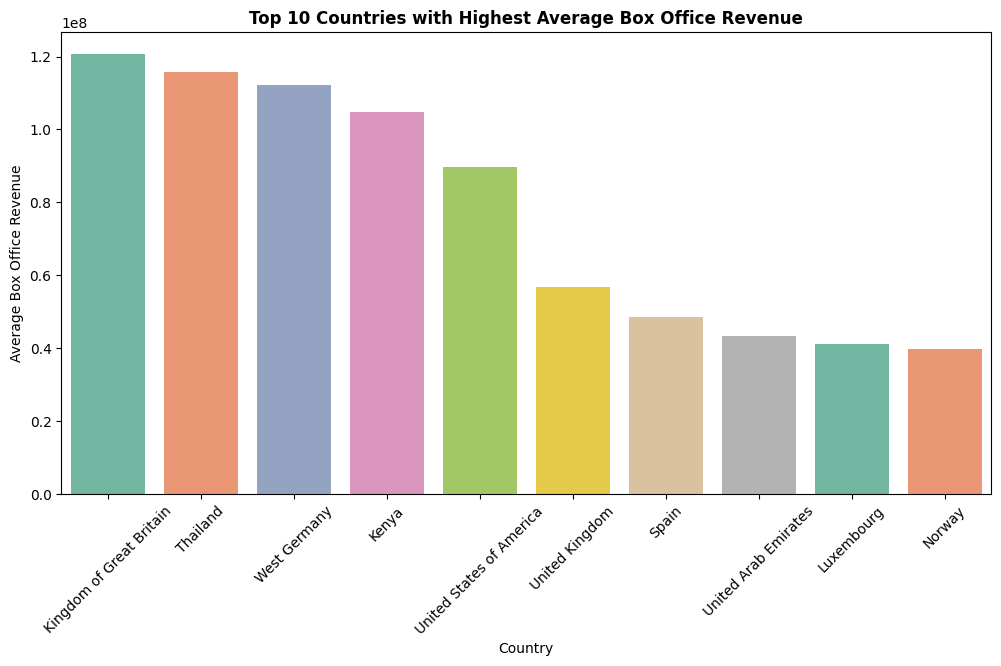

In [27]:
# plot
top_n = 10

plt.figure(figsize=(12, 6))
sns.barplot(x=average_revenue_per_country.head(top_n).index, y=average_revenue_per_country.head(top_n).values, palette="Set2")
plt.title("Top 10 Countries with Highest Average Box Office Revenue", fontweight='bold')
plt.xlabel("Country")
plt.ylabel("Average Box Office Revenue")
plt.xticks(rotation=45)
plt.show()

##### Regression analysis

The country (categorical) should predict the box office revenue (continuous). An ordinary least squares (OLS) regression can be done. The categorical variable has to be one-hot encoded. Each country will get an own coefficient, indicating its influence on the box office revenue compared to the baseline country.

In [27]:
# one-hot encode the country column
# baseline country -> the most common country
X = pd.get_dummies(df_movie_country['first_country'], drop_first=True).astype(int)

y = np.log10(df_movie_country['inflated_revenue'].astype(float))

# Add intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       inflated_revenue   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     10.22
Date:                Wed, 13 Nov 2024   Prob (F-statistic):           7.89e-95
Time:                        21:44:25   Log-Likelihood:                -13944.
No. Observations:                9433   AIC:                         2.802e+04
Df Residuals:                    9368   BIC:                         2.848e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
# todoooooooo -> take a threshold and remove the languages with less than that threshold
# then do the same analysis again
# make a fancy plot for the country
# comment the results
# anova with log revenue -> create a new column first, then do the same

##### ANOVA

An ANOVA analysis can be done in order to determine if there are statistically significant differences in box office revenue across different countries.

In [30]:
# define and fit the model
anova_model = ols('inflated_revenue ~ C(first_country)', data=df_movie_country).fit()
# get the anova table
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print(anova_table)

                        sum_sq      df         F        PR(>F)
C(first_country)  6.095020e+18    64.0  2.461818  9.507744e-10
Residual          3.623982e+20  9368.0       NaN           NaN


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Analysis of what has been found
  
</div>

### Relation between language and country

How are language and country correlated? What does this imply for previous and/ or further analysis?

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the correlation between the country and the language
  - Use the information to guide further anaylsis and to interpret previous one

</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Statistical hypothesis testing
  - Correlation analysis
  - Regression analyis
  
</div>

### Multilingual movies

Do multilingual movies have more success (in terms of box office revenues)? Is there a relationship between the number of languages spoken in a movie and its box office revenue?

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the influence of multilinguality in the movies
  - Keep in mind that if a movie has more than one language listed, it means the languages used in the original version (not the translations later on)

</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Statistical hypothesis testing (for the number of languages)
  
</div>